In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

import glob
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from scipy.optimize import curve_fit

from pathlib import Path
import itertools
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def power_law(x,alpha,beta):
    return alpha*x**beta

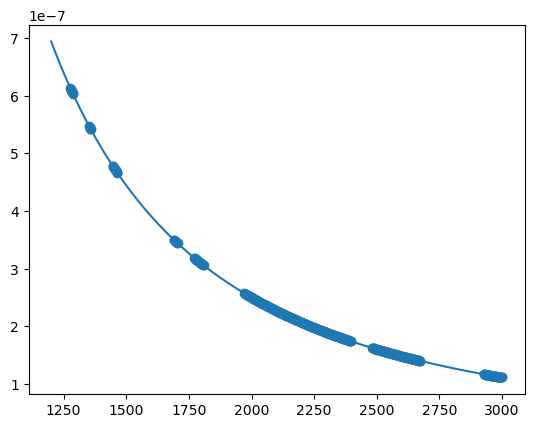

In [3]:
r1a, r1b = 1150,1170
r2a, r2b = 1275,1290
r3a, r3b = 1350,1360
r4a, r4b = 1445,1465
r5a, r5b = 1690,1705
r6a, r6b = 1770,1810
r7a, r7b = 1970,2400
r8a, r8b = 2480,2675
r9a, r9b = 2925,3400

As = [r2a,r3a,r4a,r5a,r6a,r7a,r8a,r9a]
Bs = [r2b,r3b,r4b,r5b,r6b,r7b,r8b,r9b]
wl = np.linspace(1200,3000,1000)
mask = np.zeros(len(wl),dtype=bool)
for i,m in enumerate(As):
    mask = np.logical_or(mask, (wl > As[i]) & (wl < Bs[i]))

popt,pcov = curve_fit(power_law, wl[mask], power_law(wl[mask],1,-2))


plt.scatter(wl[mask],power_law(wl[mask],1,-2))
plt.plot(wl,power_law(wl,*popt))
plt.show()

In [4]:
epath = '/media/bartosz/USB STICK/BOSS_DR14_ext/'

spec_folder = ['spectra_07_2/','spectra_2_3/','spectra_3_4/']

In [5]:
#f = '/media/bartosz/USB STICK/BOSS_DR14/normed/6_spec-4354-55810-646_0_norm.txt'
cat_id,spec_id = [],[]
alpha,beta,alpha_sig,beta_sig = [],[],[],[]
rsq = []
failed_id = []
first,second = 0,0

for sf in spec_folder:
    
    for i,f in enumerate(glob.glob(epath + sf + 'fits/' + '*.txt')):
        # f = '/media/bartosz/USB STICK/BOSS_DR14/normed/6_spec-4354-55810-646_0_norm.txt'
    
        norm = np.loadtxt(f)
        wl,flux = norm[:,0],norm[:,1]
        # cnt = np.count_nonzero(sig==0)
        # print(cnt)
        # continue
        
        file_name = Path(f).stem
        file_info = file_name.split('_')
        
        mask = np.zeros(len(wl),dtype=bool)
        if 0 in flux[wl>r9a]:
            N = len(As)-1
        else: N = len(As)
            
        for j in range(N):
            mask = np.logical_or(mask, (wl > As[j]) & (wl < Bs[j]))
        # mask = np.logical_and(mask, sig>0)
    
        # # mask uncertainties >2sigma
        # sig_mean = np.mean(sig[mask])
        # sig_stdev = np.std(sig[mask])
        # mask = np.logical_and(mask,sig<sig_mean+3*sig_stdev)
        
        try:    
            #popt,pcov = curve_fit(power_law,wl[mask],flux[mask],sigma=sig[mask],absolute_sigma=True,maxfev=1000)
            popt,pcov = curve_fit(power_law,wl[mask],flux[mask],maxfev=1000)
            
        except RuntimeError:
            print(i, 'RuntimeError: 1st iteration')
            first += 1
            failed_id.append(file_info[0])
            continue
    
        diff = abs(flux - power_law(wl,*popt))
        diff_mean = np.mean(diff[mask])
        diff_stdev = np.std(diff[mask])
        mask2 = np.logical_and(mask,diff<diff_mean+3*diff_stdev)
    
        try:
            popt,pcov = curve_fit(power_law,wl[mask2],flux[mask2],bounds=([popt[0],-np.inf],[np.inf,popt[1]]),maxfev=1000)
    
        except RuntimeError:
            print(i, 'RuntimeError: 2nd iteration; idx {}'.format(file_info[0]))
            second += 1
            failed_id.append(file_info[0])
            continue

        res = np.sum( (flux[mask2]-power_law(wl[mask2],*popt))**2 )
        tot = np.sum( (flux[mask2]-np.mean(flux[mask2]))**2 )
        r_squared = 1 - res/tot

        cat_id.append(int(file_info[0]))
        spec_id.append(file_info[1])
        
        alpha.append(popt[0])
        beta.append(popt[1])
        alpha_sig.append(np.sqrt(pcov[0][0]))
        beta_sig.append(np.sqrt(pcov[1][1]))

        rsq.append(r_squared)
        
        if i%1000 == 0:
            print(i)

pl_save='power_law_fits_spline_rsqmask2_cl_bound'
with open(epath + pl_save + '.txt','w') as plsave:
    for x in itertools.zip_longest(cat_id,spec_id,alpha,alpha_sig,beta,beta_sig,rsq):
        plsave.write('{} \t {} \t {} \t {} \t {} \t {} \t {} \n'.format(*x))
plsave.close()

print(first, '1st iteration RuntimeErrors; ', second, '2nd iteration RuntimeErrors')
print('index of failed spectra:')
for f in failed_id:
    print(f)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
0
726 RuntimeError: 1st iteration
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
0
1000
2000
3000
4000
5000
6000
7000
8000
1 1st iteration RuntimeErrors;  0 2nd iteration RuntimeErrors
index of failed spectra:
72694


In [30]:
# pl_save='power_law_fits'
# with open(epath + pl_save + '.txt','w') as plsave:
#     for x in itertools.zip_longest(cat_id,spec_id,alpha,alpha_sig,beta,beta_sig):
#         plsave.write('{} \t {} \t {} \t {} \t {} \t {} \n'.format(*x))
# plsave.close()

In [9]:
pls = np.loadtxt(epath+'power_law_fits_spline_rsq.txt',dtype='str')
pls=pls[:-1]
alphas,betas = np.array([float(a) for a in pls[:,2]]),np.array([float(b) for b in pls[:,4]])

alpha_sig = np.array([np.sqrt(float(s)) for s in pls[:,3]])
beta_sig = np.array([np.sqrt(float(s)) for s in pls[:,5]])

print(alpha_sig)
print(pls[:,0])

[8.00240563e+01 6.06857095e+01 1.83189159e+01 ... 8.22731789e+04
 6.26354656e+02 5.16228657e+02]
['185430' '268822' '34302' ... '99878' '9987' '99968']


In [10]:
x = np.linspace(1200,3000,500)

slope =  np.array([alphas[i]*betas[i] for i in range(len(alphas))])
neg = slope < 0
pos = slope > 0
zer = slope == 0
print(len(alphas[neg]))
print(len(alphas[pos]))

76350
1434


In [12]:
import random

sample = sorted(random.sample(range(len(pls[:,0])),100))

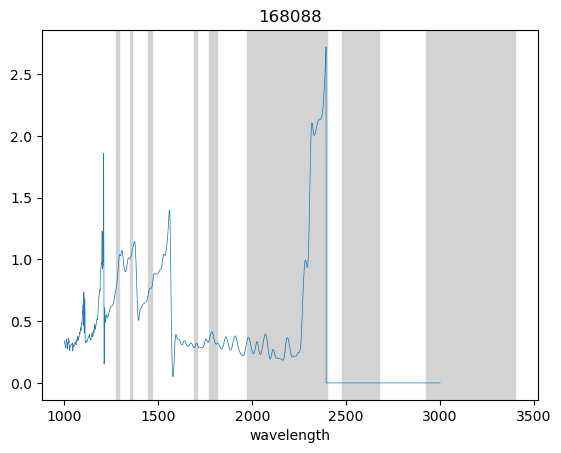

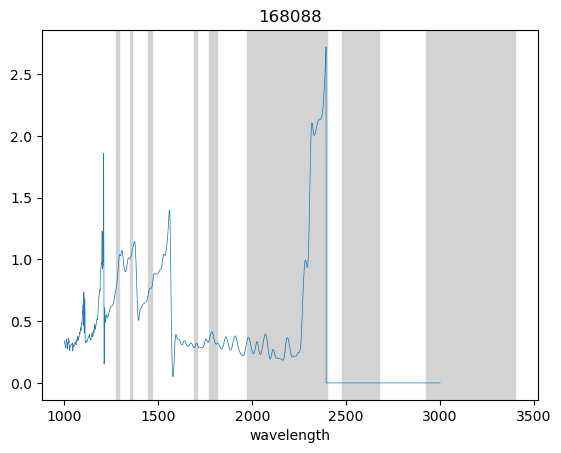

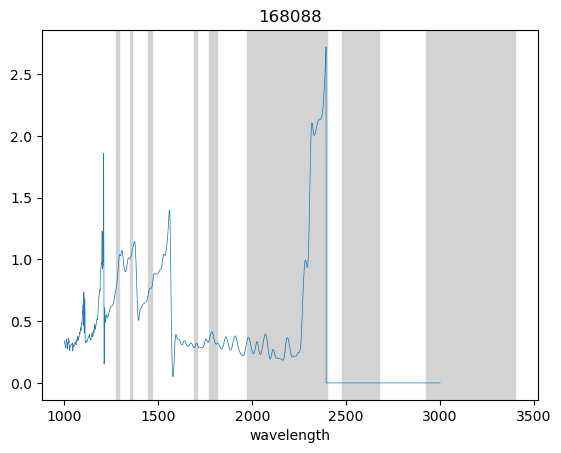

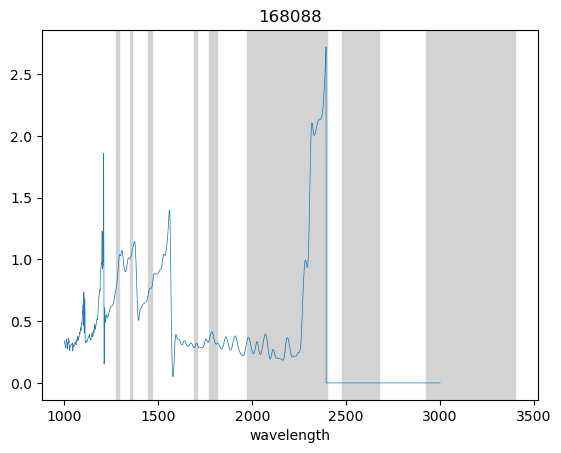

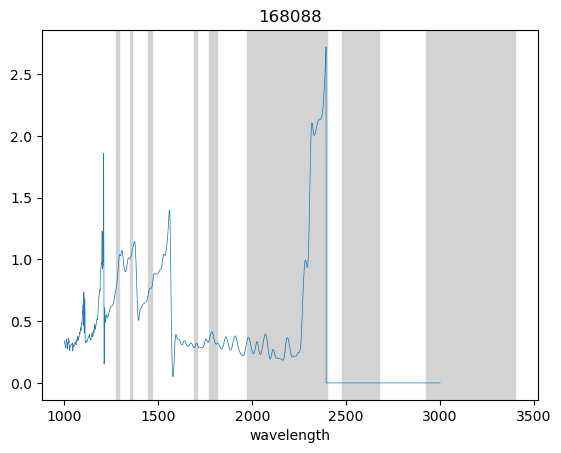

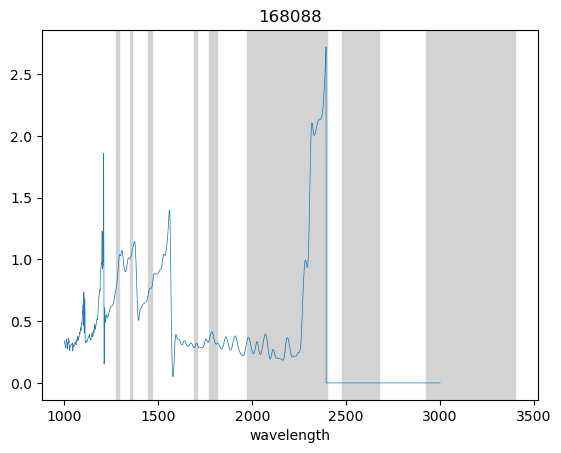

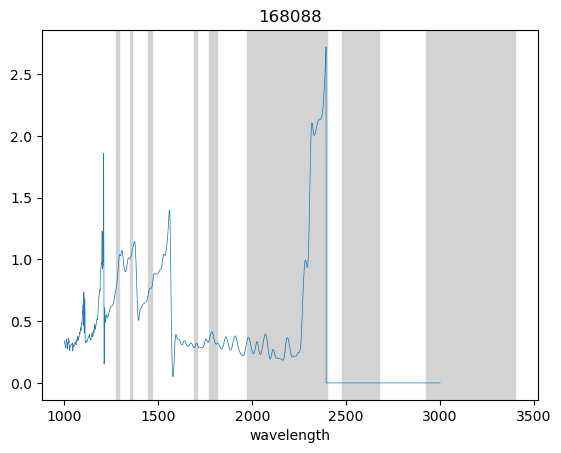

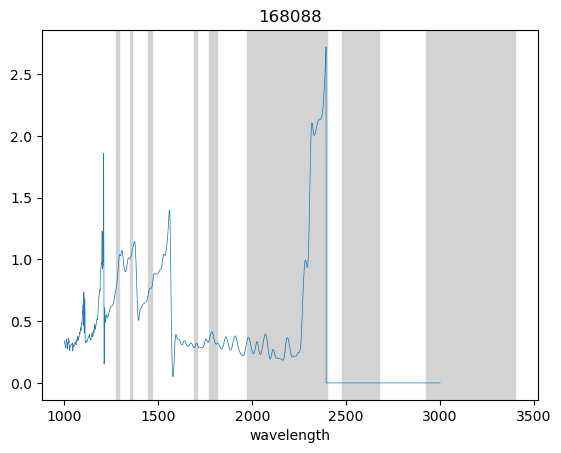

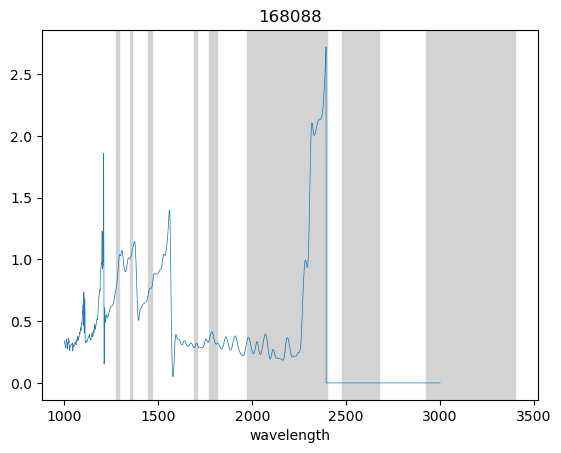

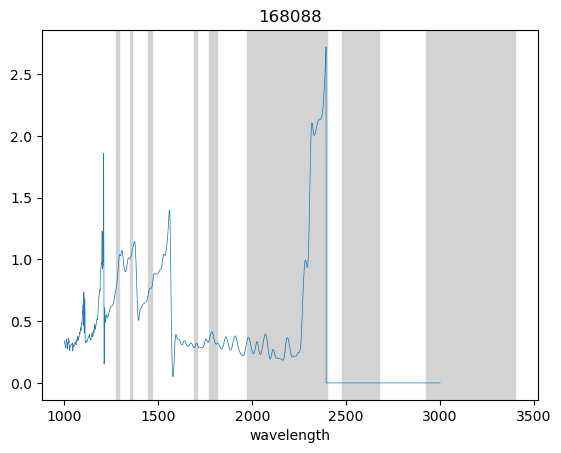

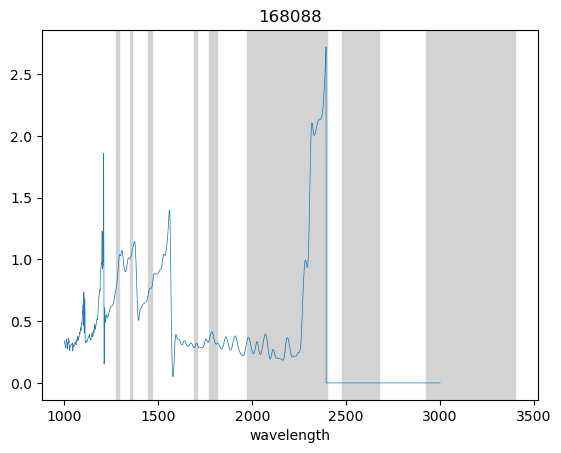

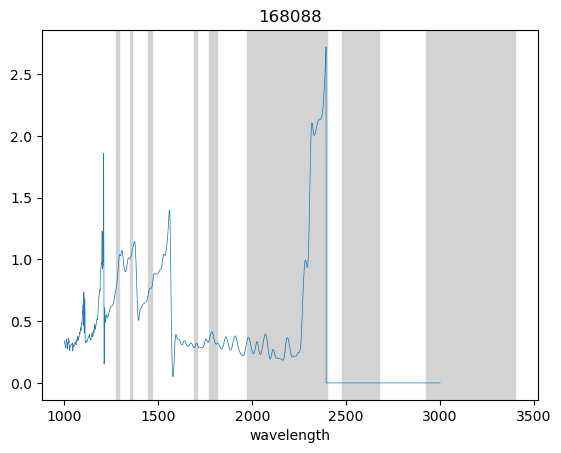

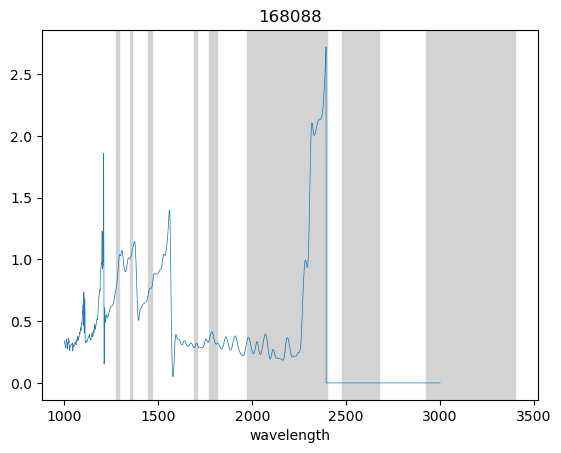

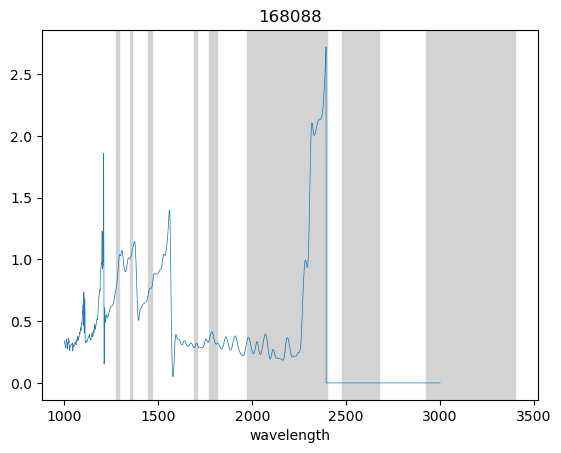

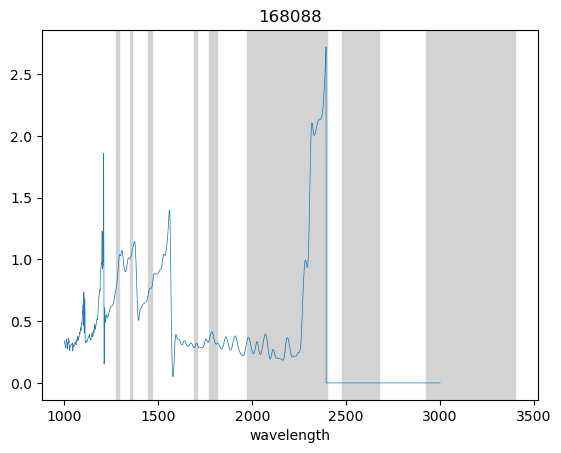

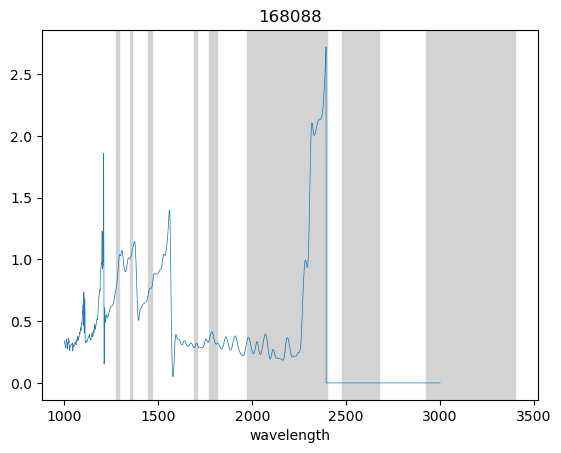

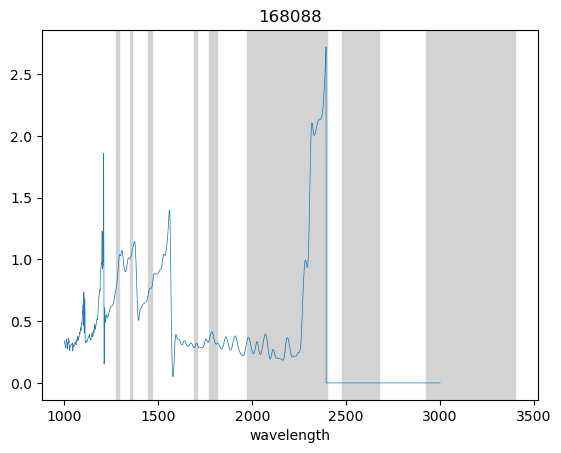

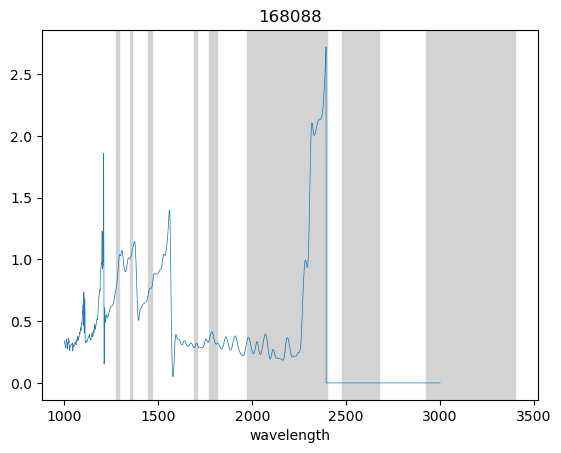

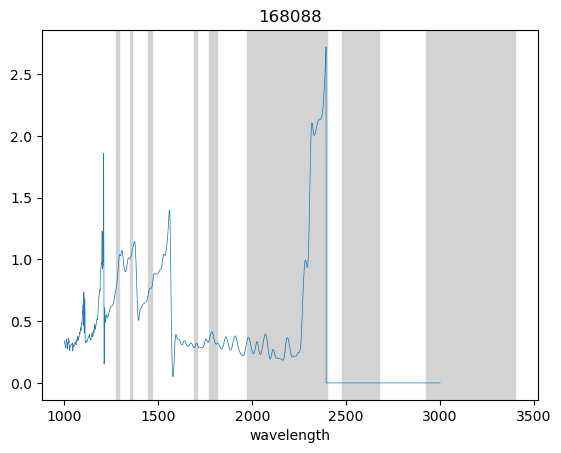

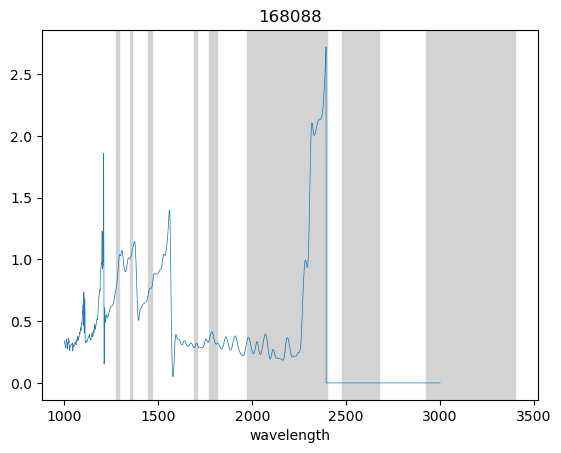

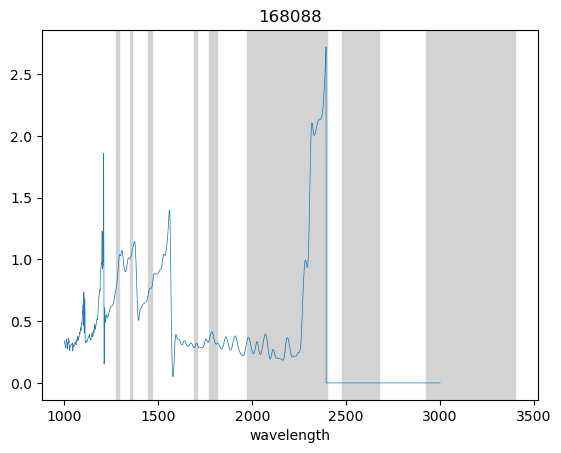

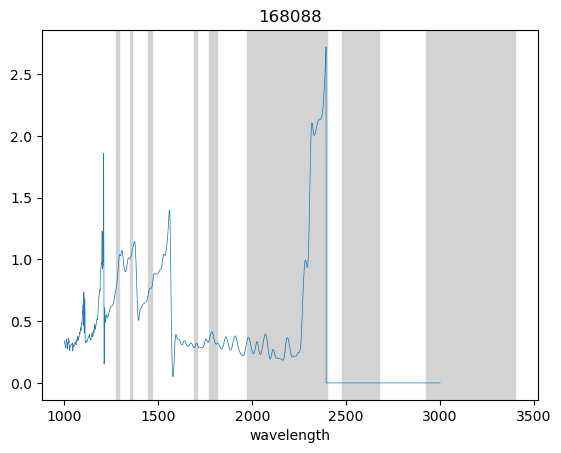

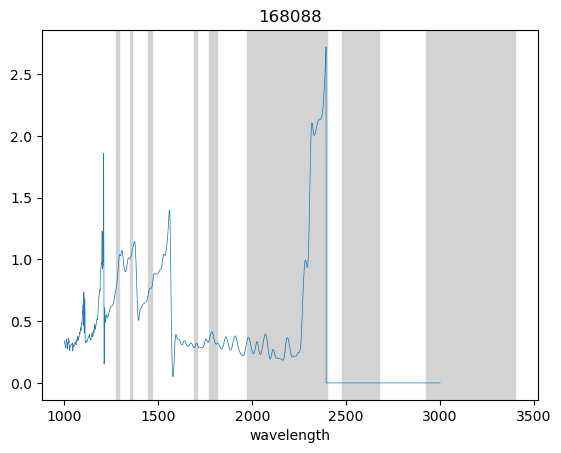

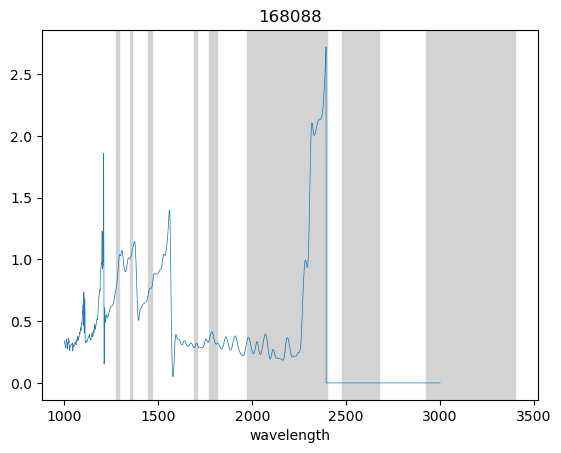

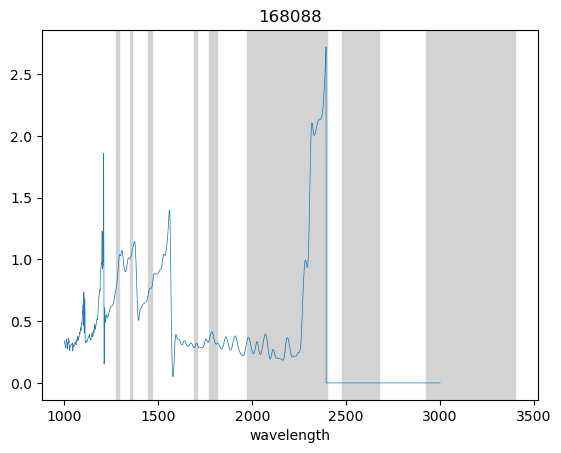

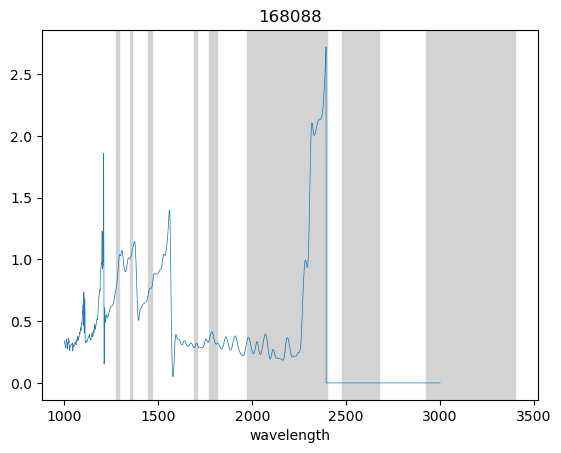

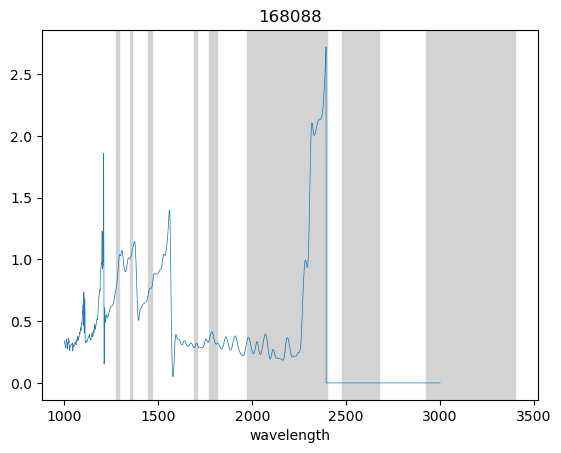

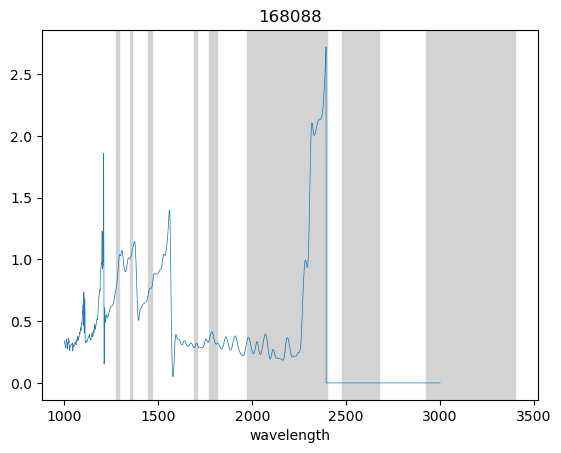

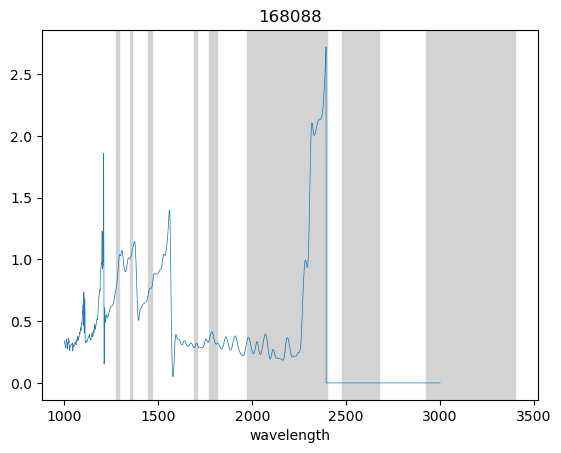

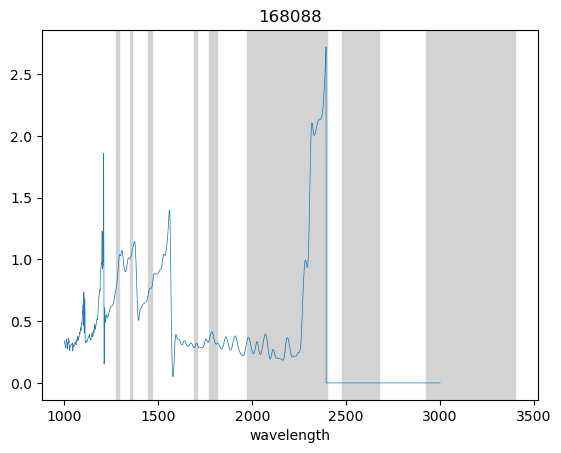

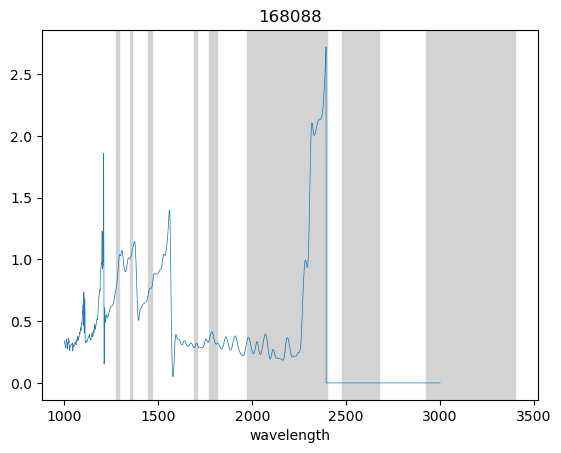

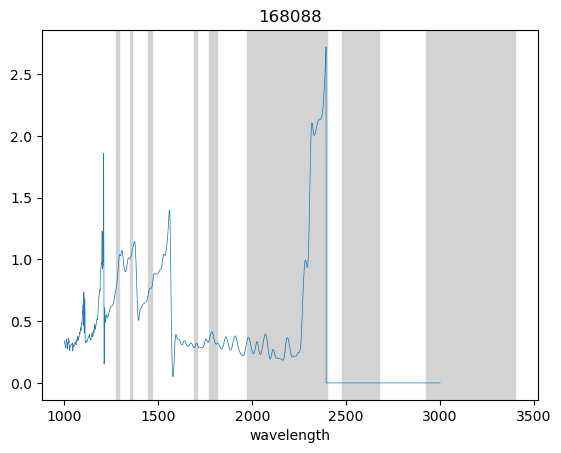

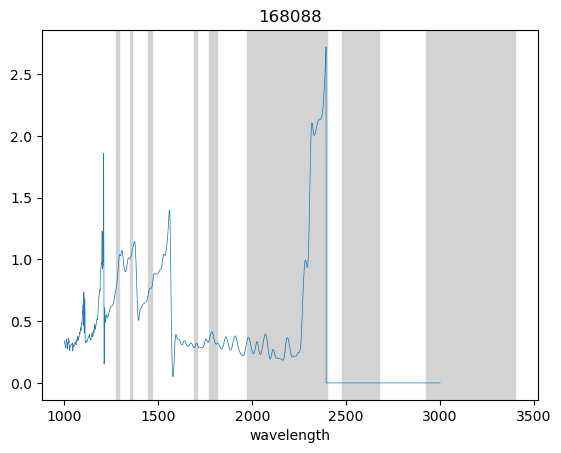

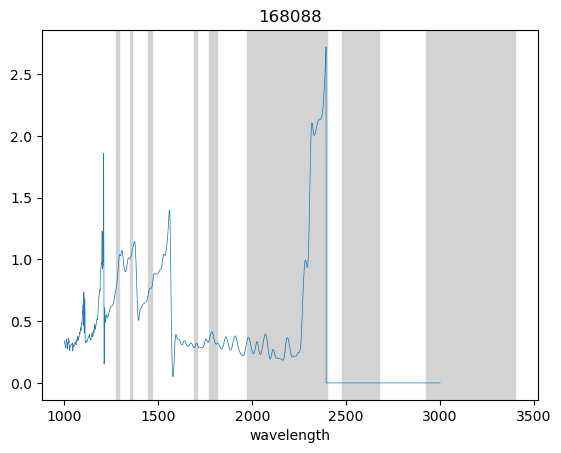

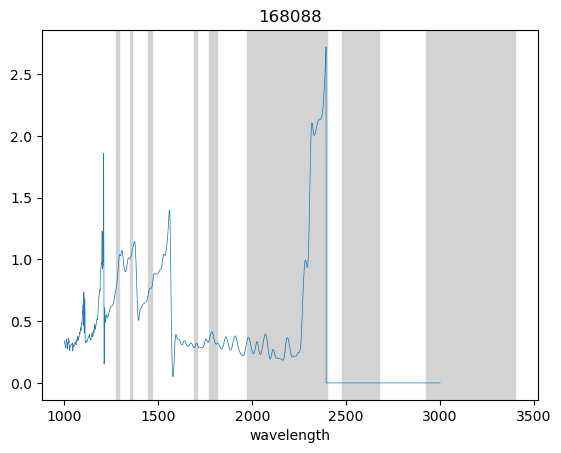

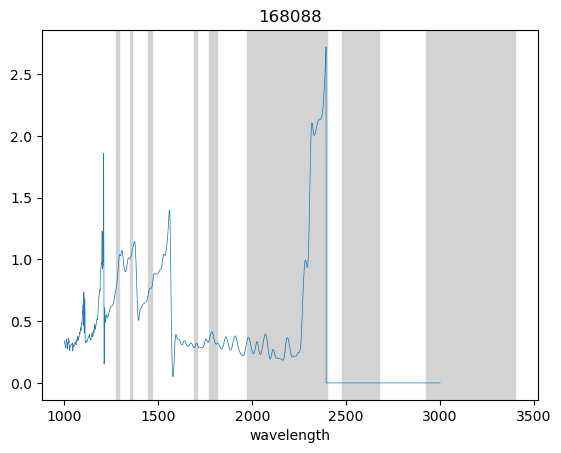

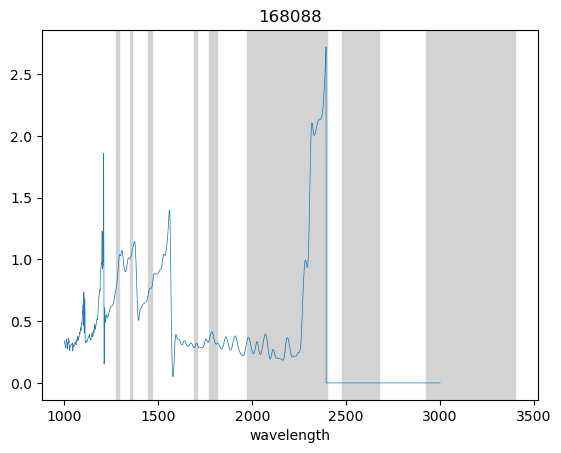

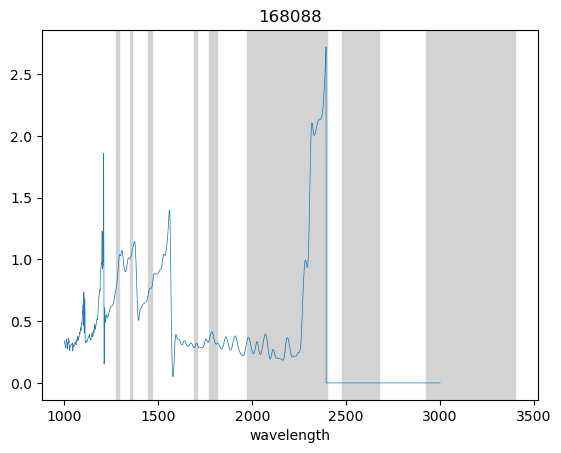

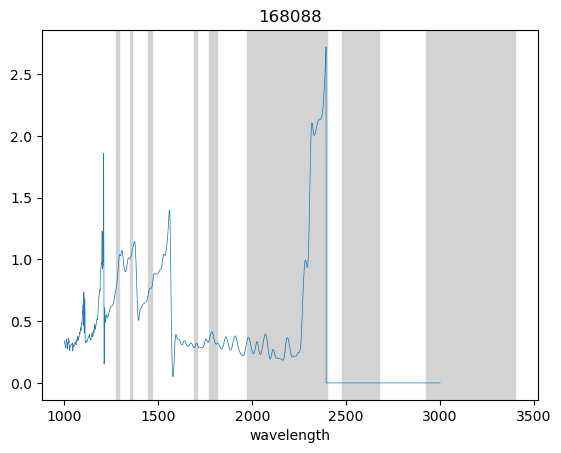

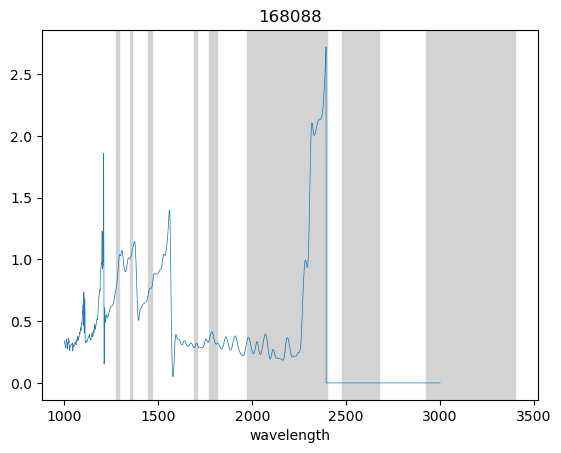

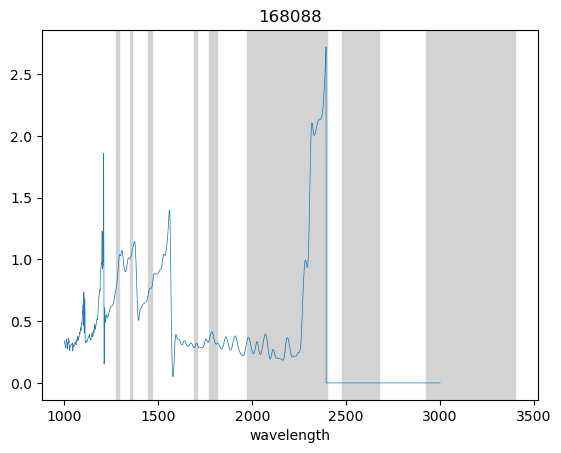

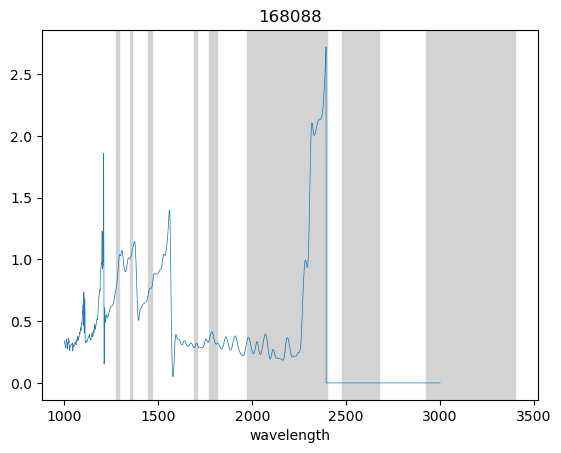

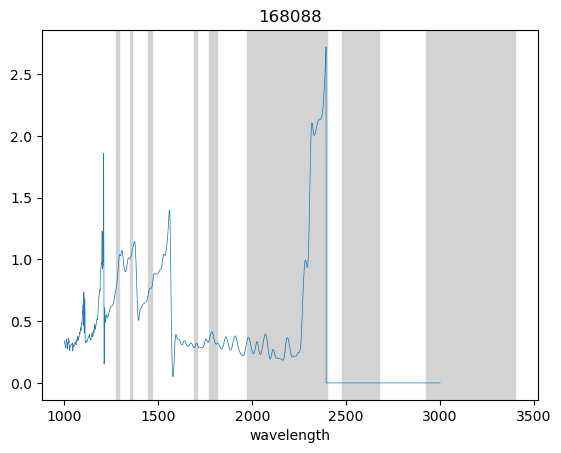

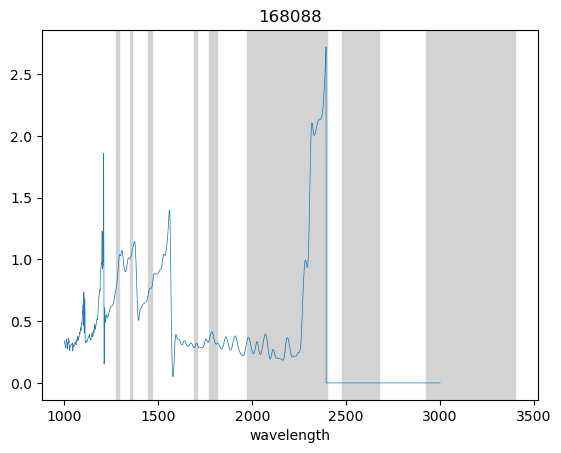

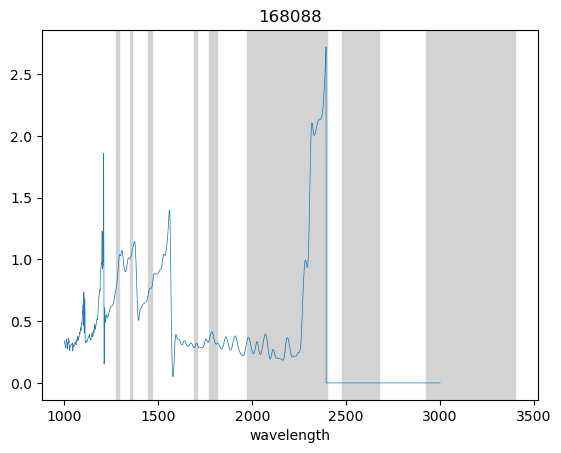

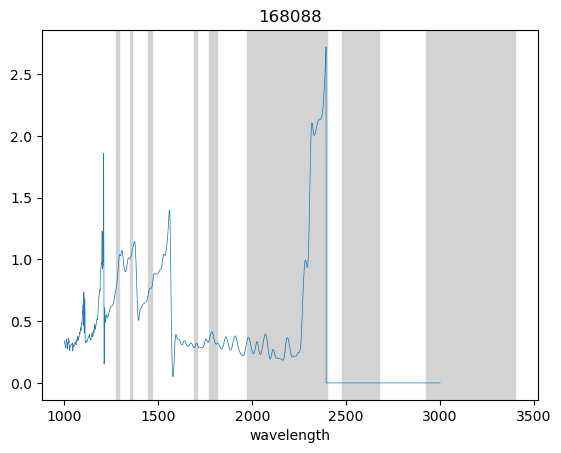

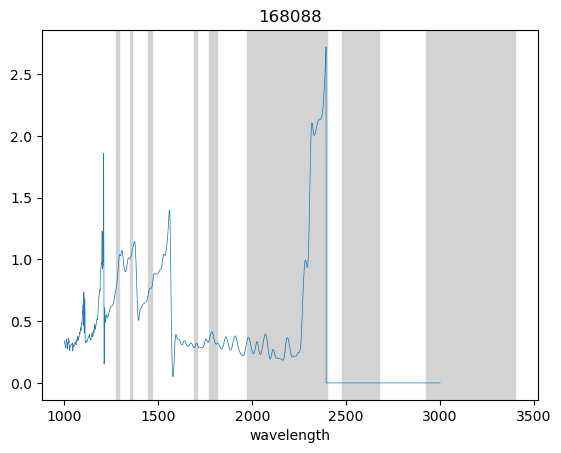

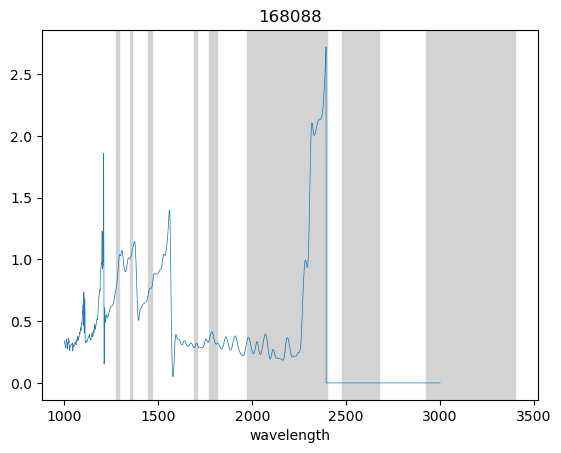

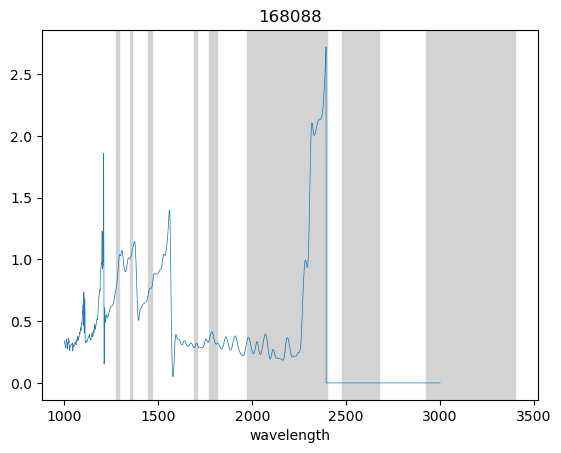

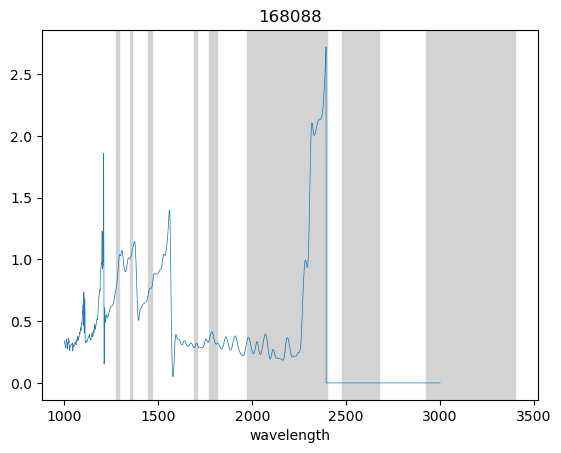

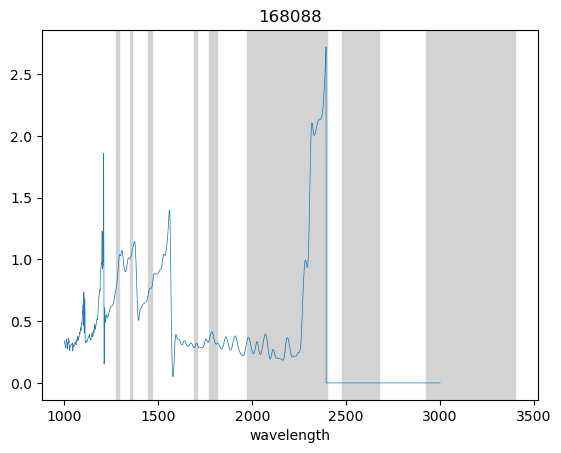

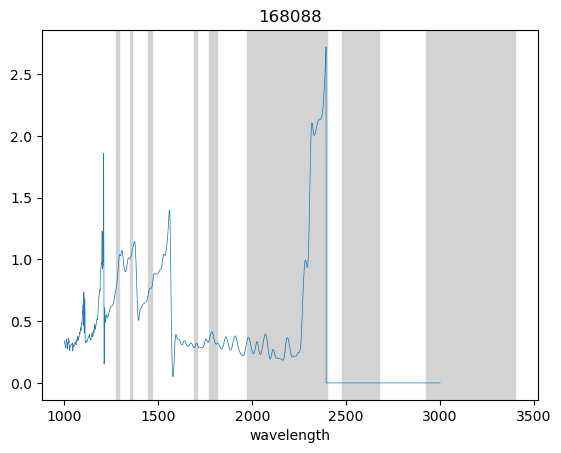

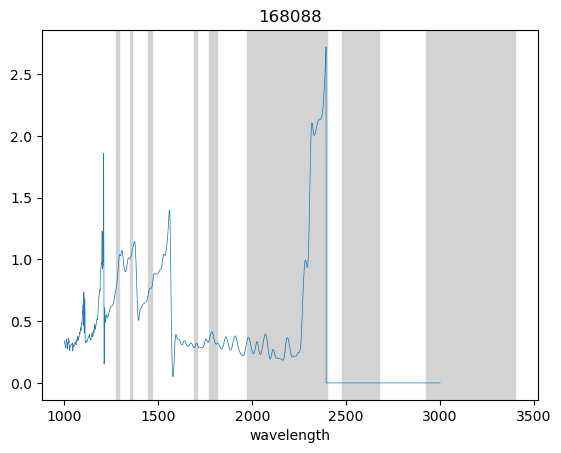

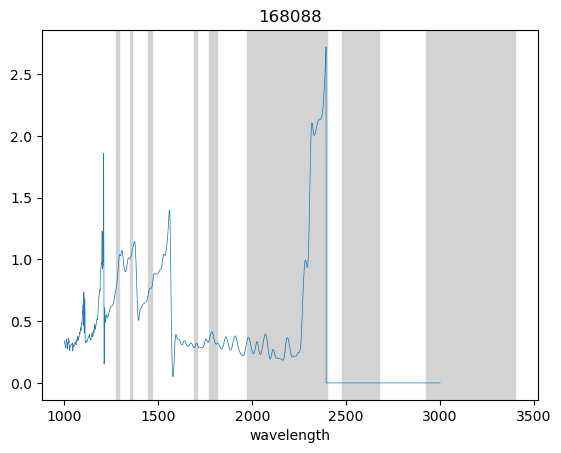

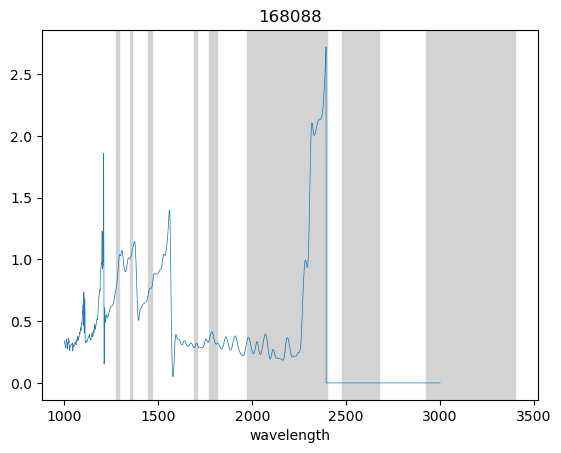

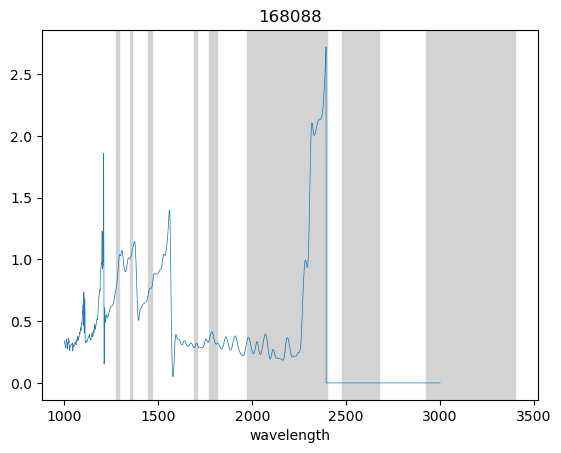

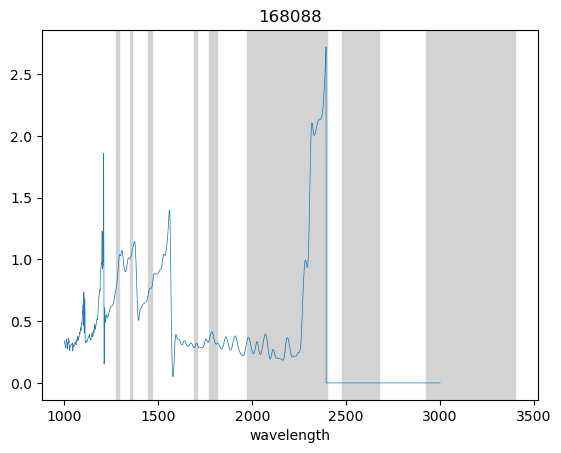

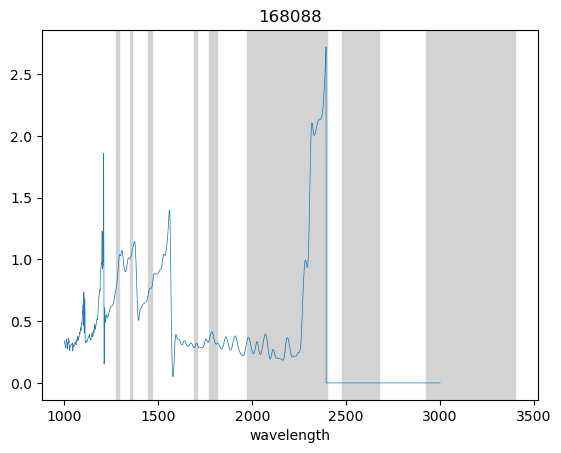

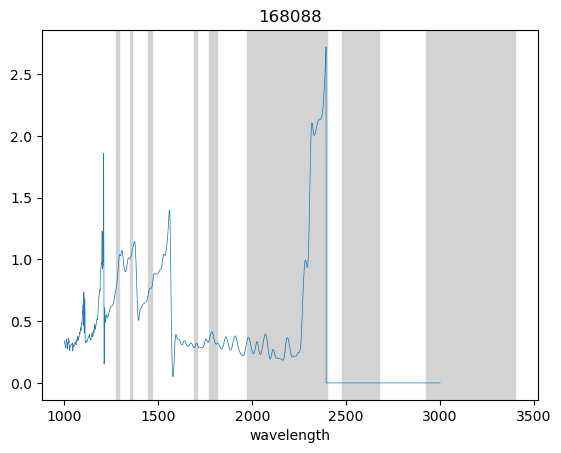

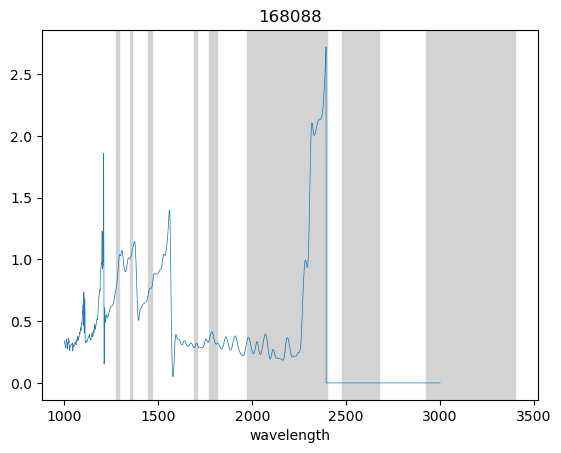

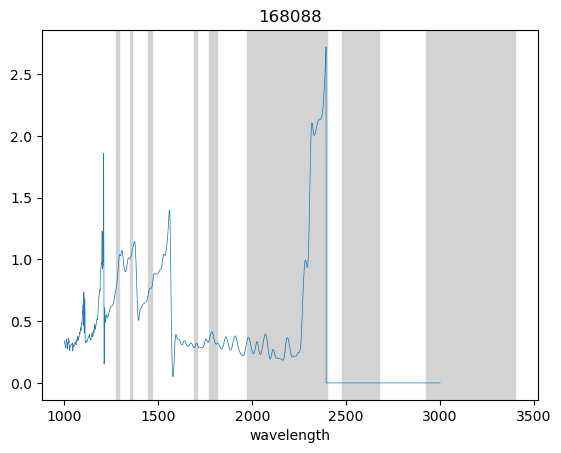

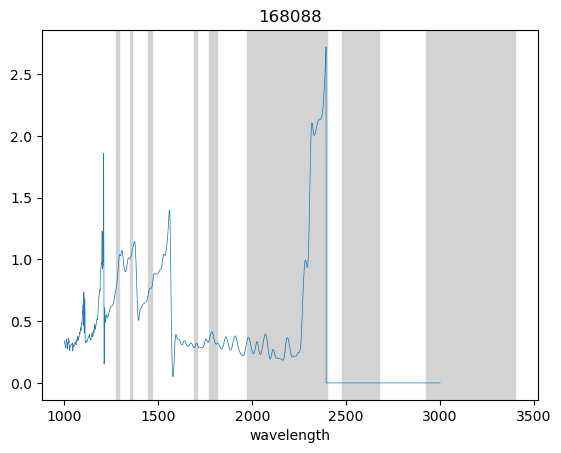

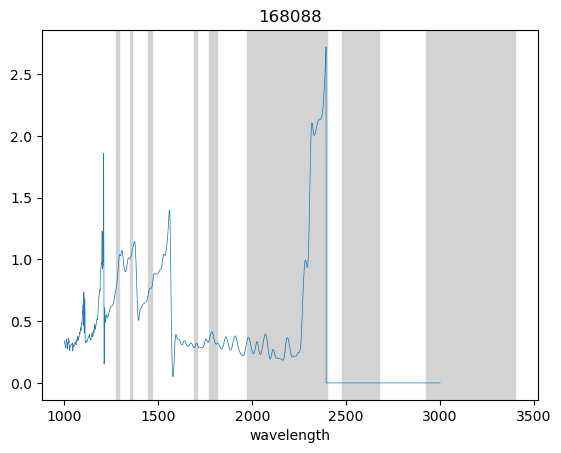

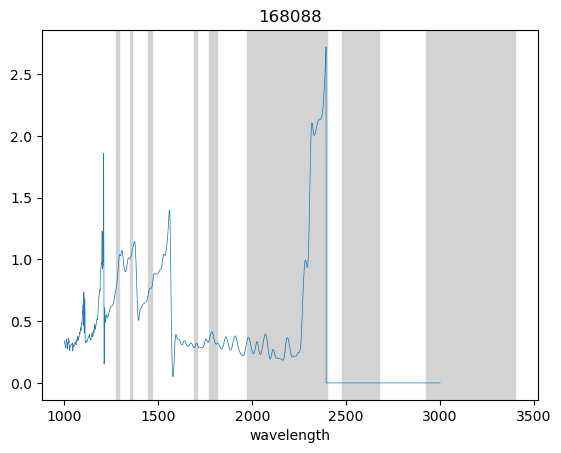

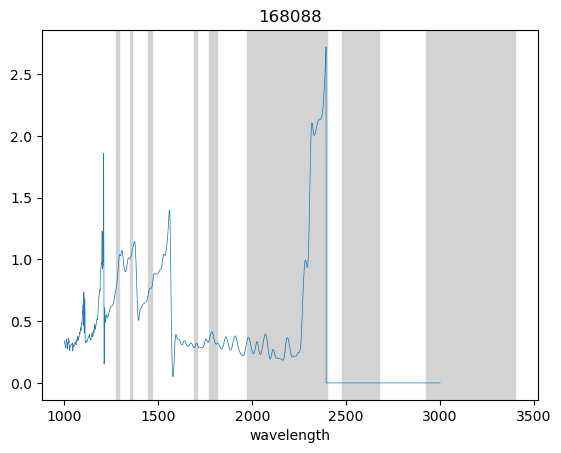

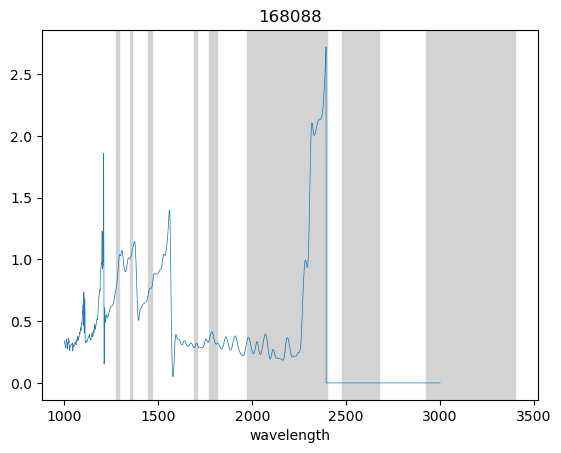

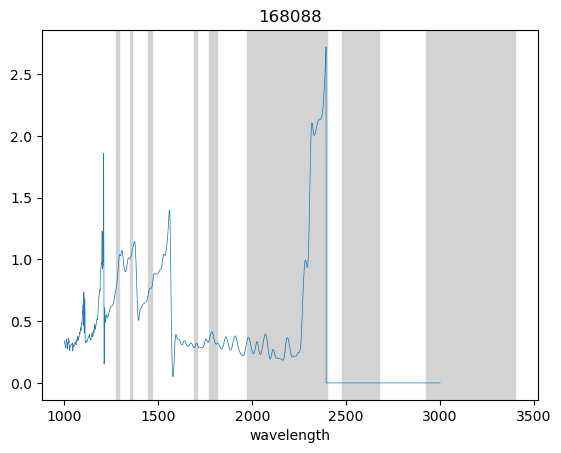

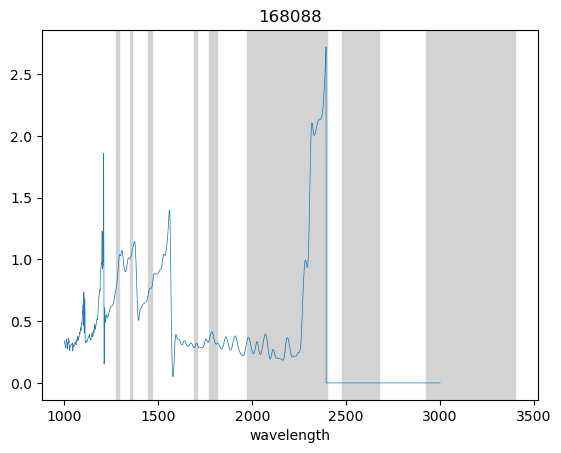

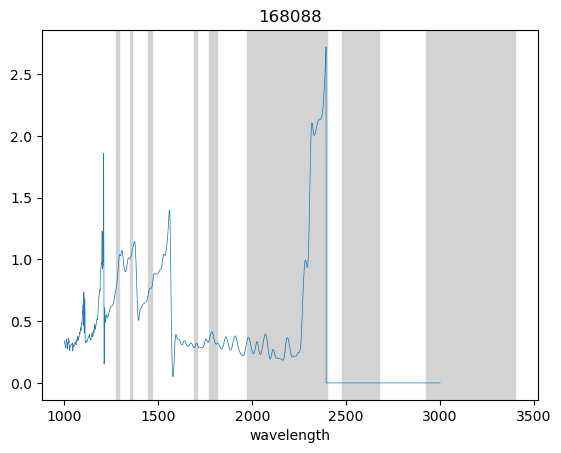

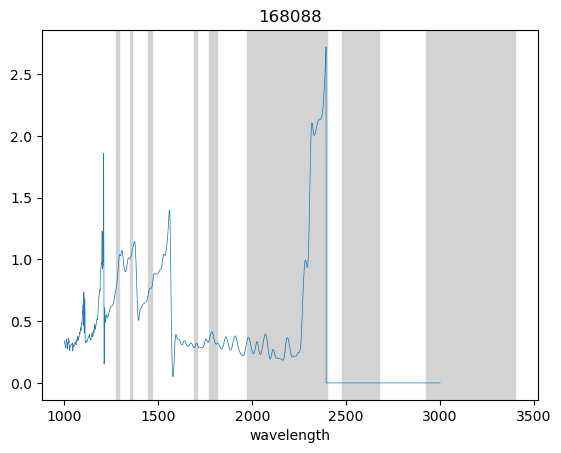

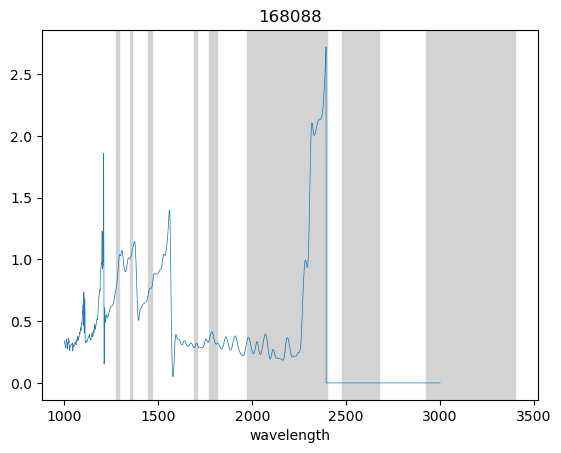

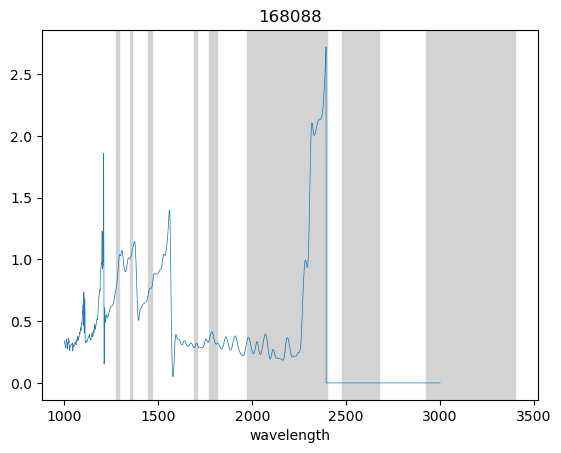

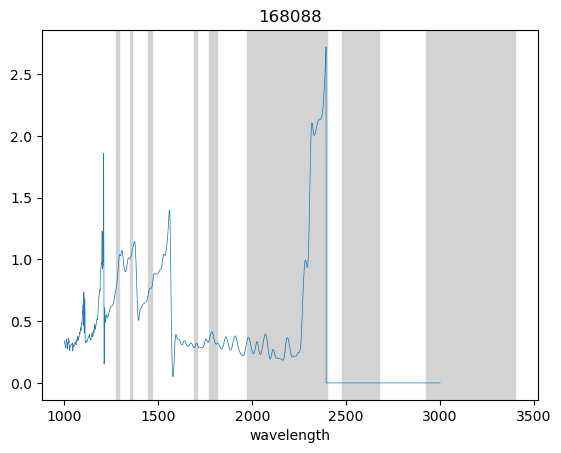

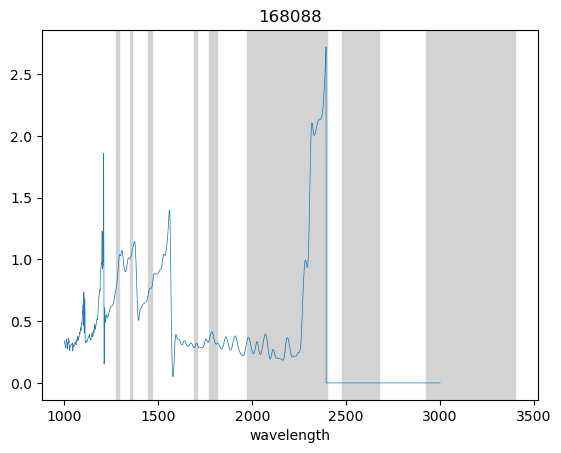

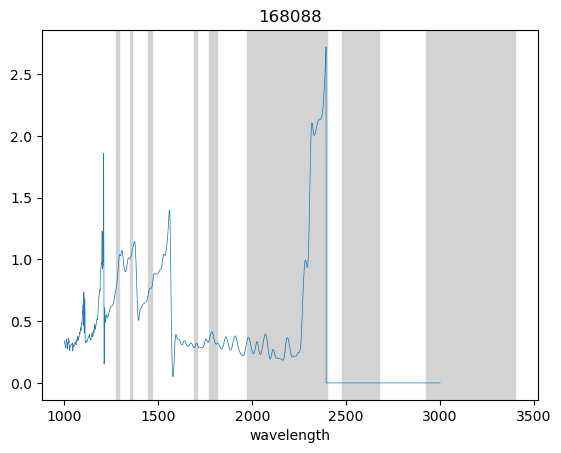

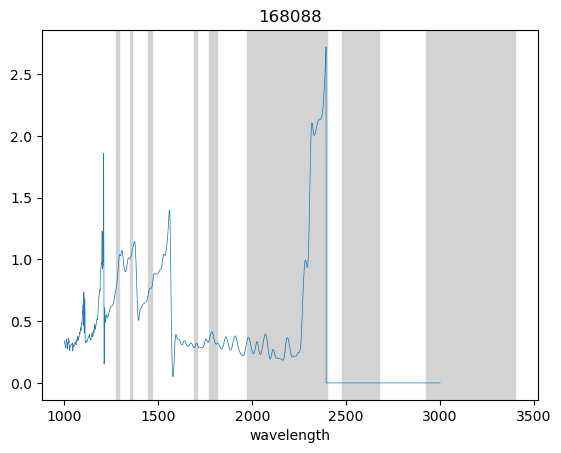

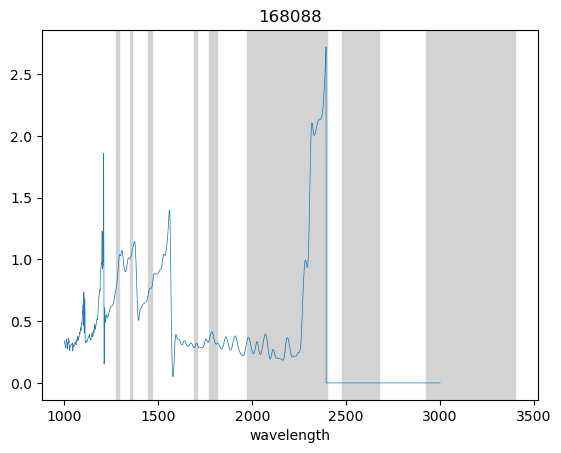

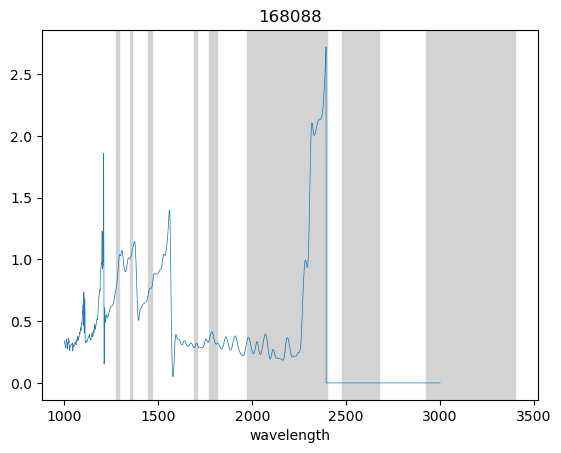

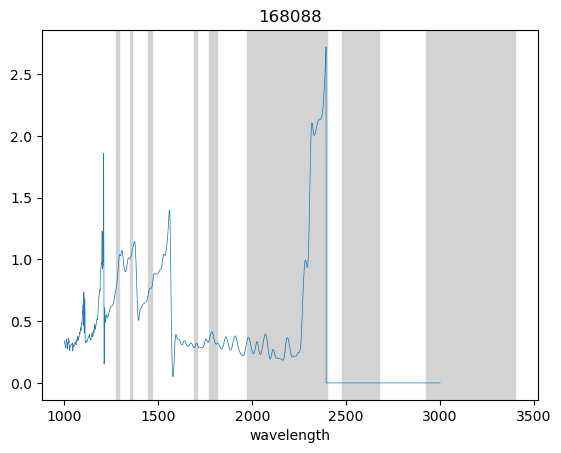

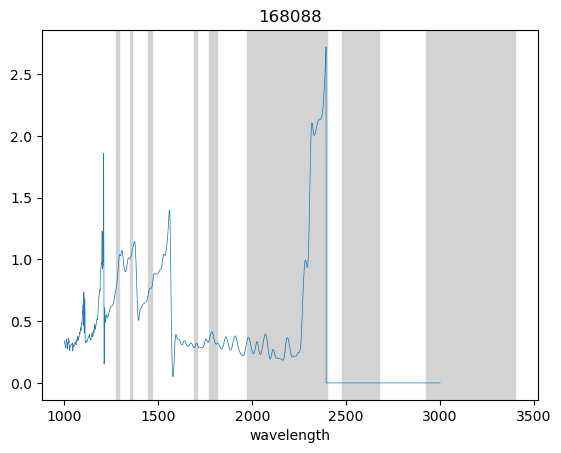

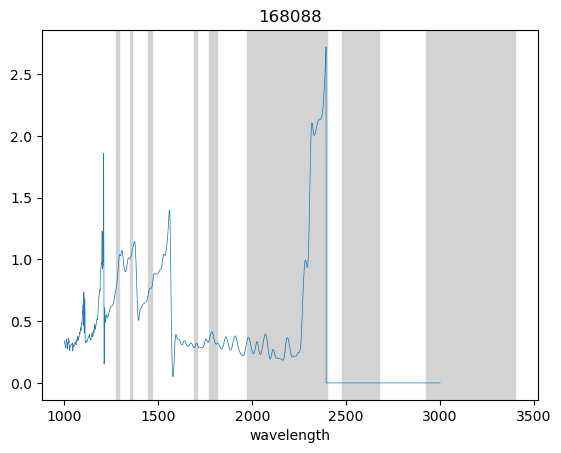

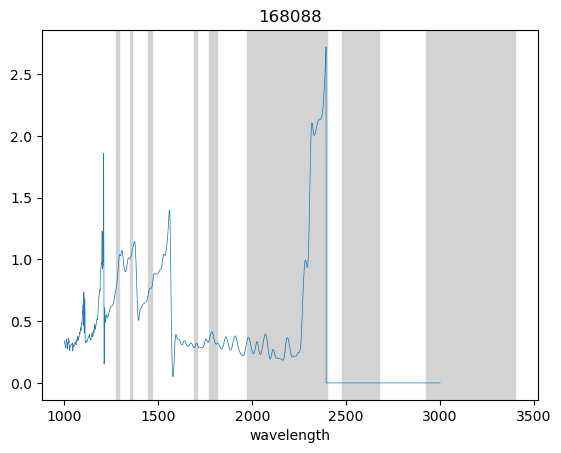

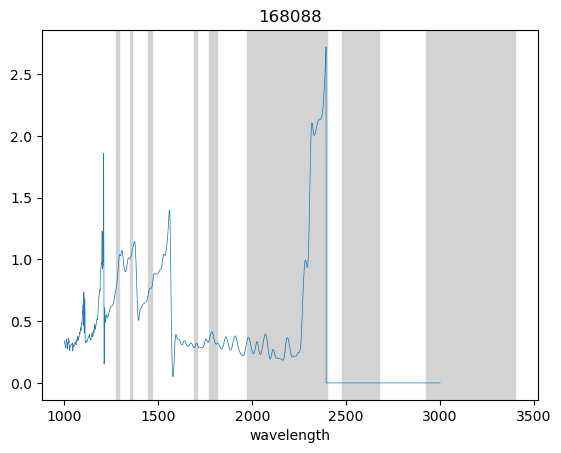

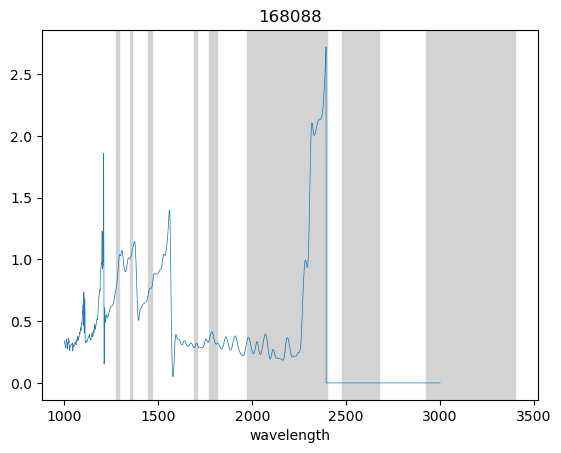

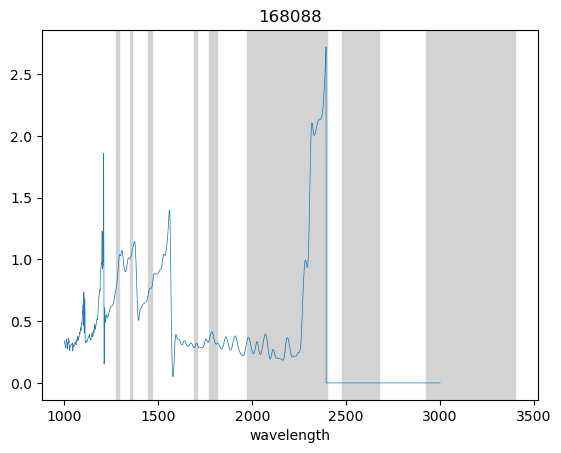

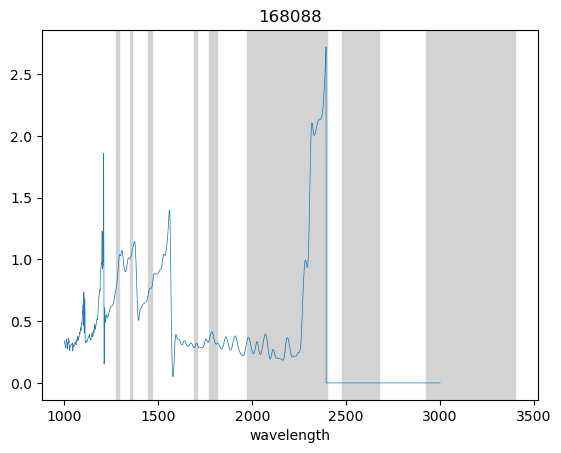

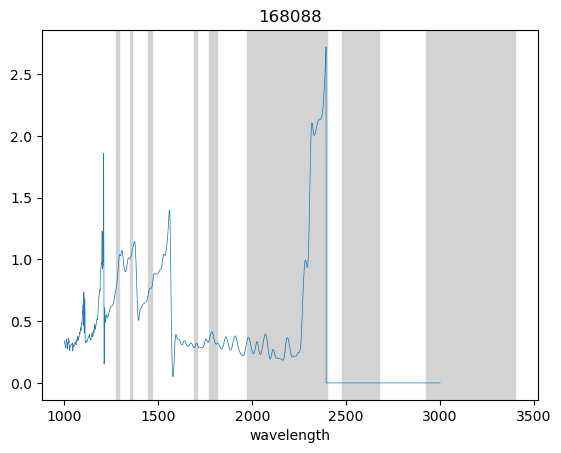

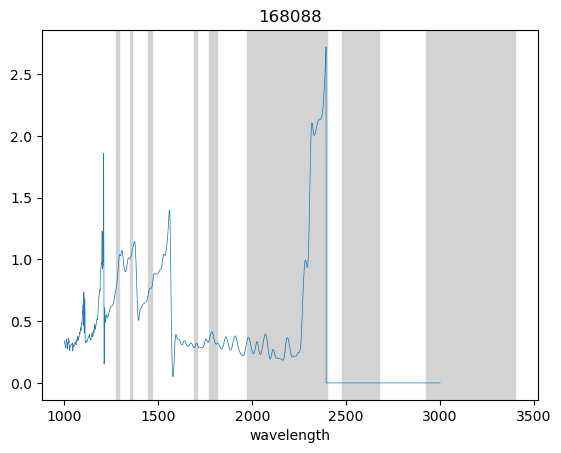

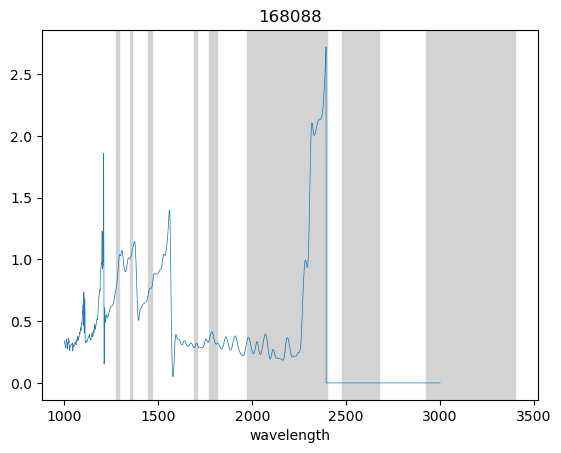

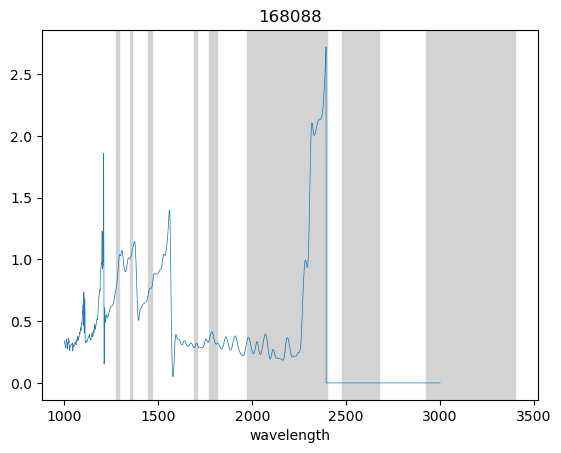

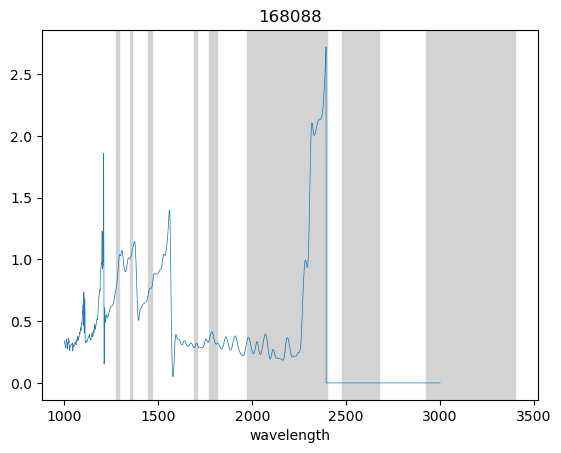

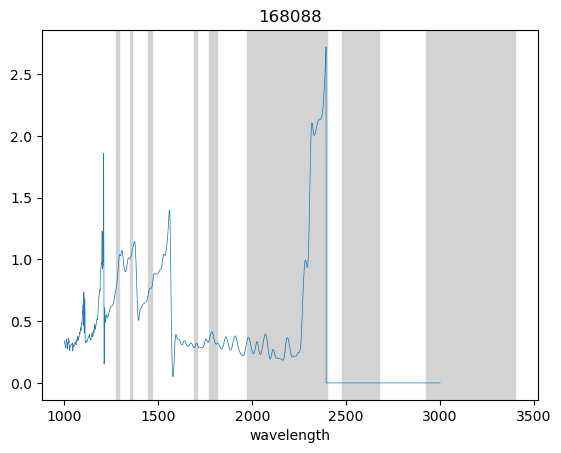

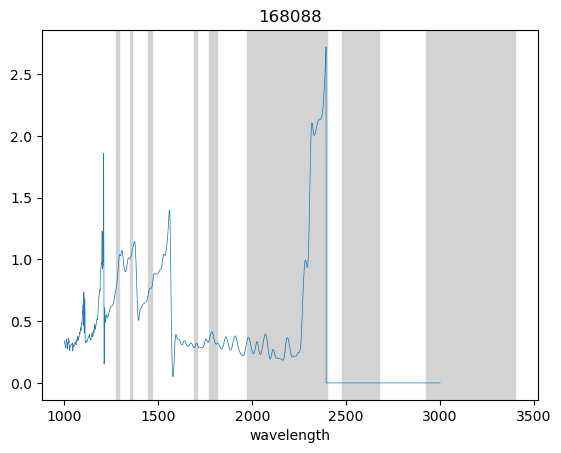

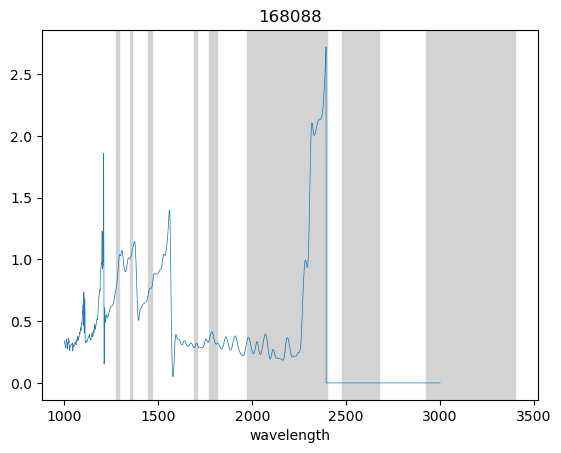

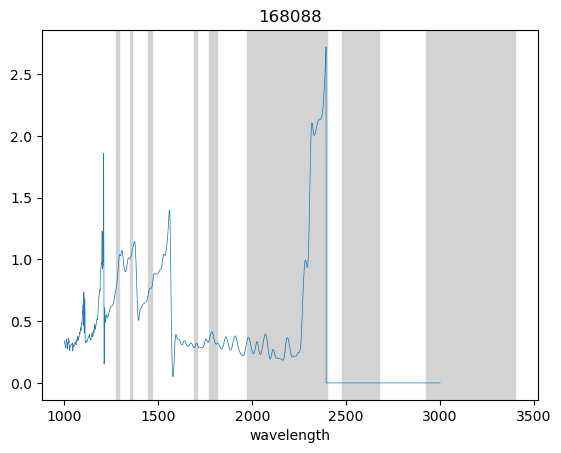

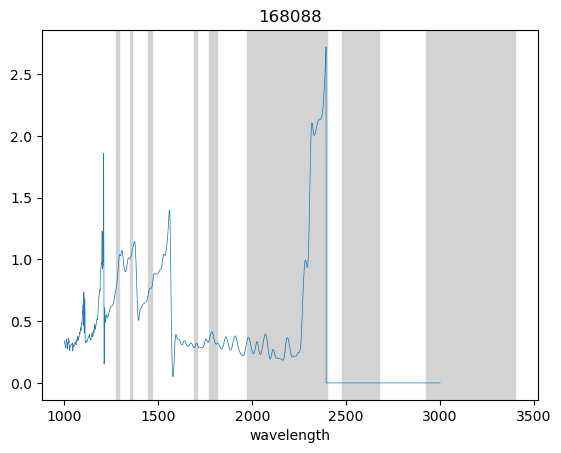

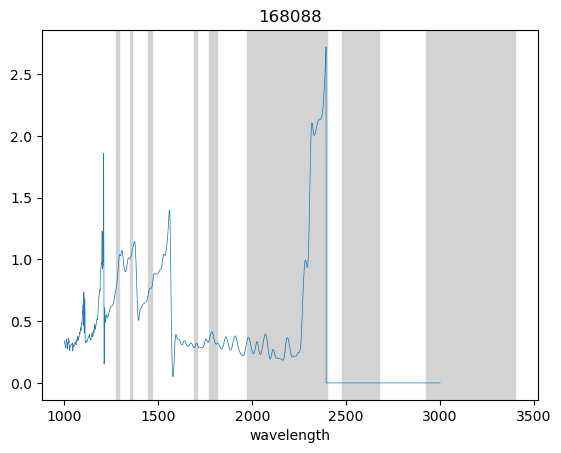

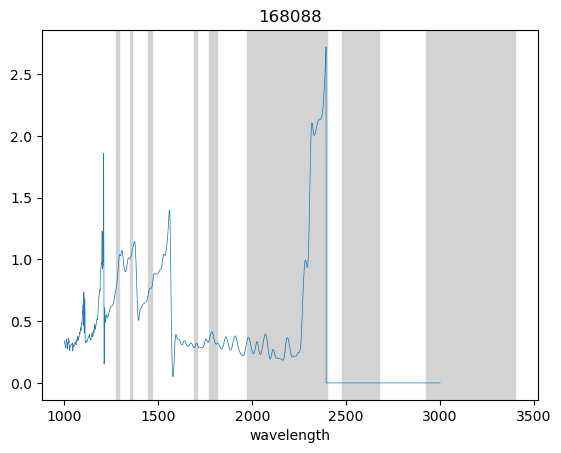

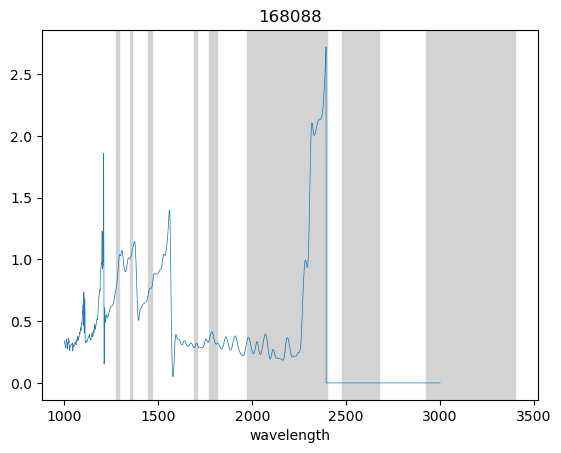

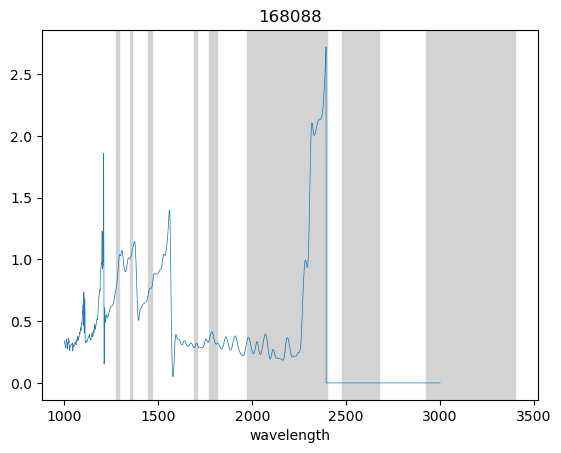

In [23]:
#pp = PdfPages('plots/rand_sample.pdf')

for i,q in enumerate(pls[:,0][sample]):
    #plt.plot(x,power_law(x,float(alphas[pos][i]),float(betas[pos][i])))
    # q = 168088
    spec = np.loadtxt(glob.glob('/media/bartosz/USB STICK/BOSS_DR14_ext/spectra_3_4/fits/' + '{}_*.txt'.format(q))[0])
    wl,flux,sig = spec[:,0],spec[:,1],spec[:,2]
    # wl,flux = spec[:,0],spec[:,1]

    median = np.median(flux)
    stdev = np.std(flux)
    mask = abs(flux)<median+5*stdev

    # mask = np.zeros(len(wl),dtype=bool)
    # for j,m in enumerate(As):
    #     mask = np.logical_or(mask, (wl > As[j]) & (wl < Bs[j]))
    # mask = np.logical_and(mask, sig>0)
    
    # # mask uncertainties >2sigma
    # sig_mean = np.mean(sig[mask])
    # sig_stdev = np.std(sig[mask])
    # mask = sig<sig_mean+2*sig_stdev

    fig = plt.figure()
    plt.title(q)
    plt.plot(wl[mask],flux[mask],drawstyle='steps-mid',lw=0.5)
    plt.plot(wl[mask],power_law(wl[mask],alphas[sample][i],betas[sample][i]),alpha=0.7,lw=0.5)
    plt.plot(wl[mask],flux[mask]-power_law(wl[mask],alphas[sample][i],betas[sample][i]),drawstyle='steps-mid',alpha=0.7,lw=0.5)
    plt.plot(wl[mask],sig[mask]-1,drawstyle='steps-mid',alpha=0.5,lw=0.5)
    for j,a in enumerate(As):
        plt.axvspan(As[j],Bs[j],color='lightgrey')
    plt.xlabel('wavelength')
   #pp.savefig(fig)
    plt.show()
    plt.close()

#pp.close()

In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Generate synthetic power-law data
np.random.seed(42)
n = 100  # number of data points
alpha_true = 2.5  # true alpha value
xmin = 1
data = (np.random.pareto(alpha_true, n) + 1) * xmin

# Define the model
with pm.Model() as model:
    # Define priors
    alpha = pm.Lognormal('alpha', mu=np.log(2), sigma=1)
    xmin = pm.HalfNormal('xmin', sigma=10)
    
    # Define likelihood
    likelihood = pm.Pareto('likelihood', alpha=alpha, m=xmin, observed=data)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, init="adapt_diag")

# Analyze the results
az.plot_trace(trace)
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(1.19314718), 'xmin_log__': array(2.30258509)}

Logp initial evaluation results:
{'alpha': -1.04, 'xmin': -0.73, 'likelihood': -inf}
You can call `model.debug()` for more details.

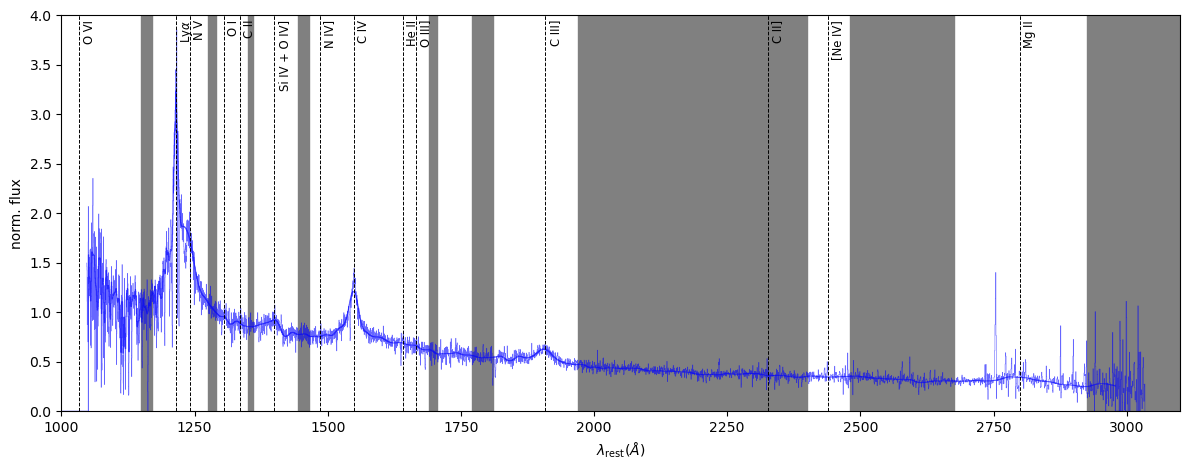